In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#visualizations
import matplotlib.pyplot as plt

import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

#text preprocessing
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
import string
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack, csr_matrix

In [ ]:
# Step 1: Load the dataset
dataset_path = "https://raw.githubusercontent.com/GuviMentor88/Training-Datasets/refs/heads/main/twitter_training.csv"
column_names = ["id", "entity", "sentiment", "tweet"]
df = pd.read_csv(dataset_path, header=None, names=column_names)
df.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df["sentiment"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [ ]:
df['sentiment'] = df['sentiment'].replace('Irrelevant', 'Neutral')
print(df['sentiment'].unique())


['Positive' 'Neutral' 'Negative']


In [ ]:
print(df['sentiment'].isnull().sum())

0


In [ ]:
# Print the first few rows and column names
print(df.head())
print(df.columns)

# Check for columns containing 'Sentiment'
print([col for col in df.columns if 'Sentiment' in col])


     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
Index(['id', 'entity', 'sentiment', 'tweet'], dtype='object')
[]


In [ ]:
df.isnull().sum()

,0
id,0
entity,0
sentiment,0
tweet,686


In [ ]:
df= df.dropna(subset=["tweet"])

In [ ]:
# Preprocessing
df = df[["tweet", "sentiment"]]


# Encode labels
label_mapping = {"Positive": 2, "Negative": 0, "Neutral": 1}
df['sentiment'] = df['sentiment'].map(label_mapping)



<ipython-input-76-5401dcb521d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment'].map(label_mapping)


In [ ]:
sentiment_counts = df['sentiment'].value_counts()

# Display the counts
print(sentiment_counts)


sentiment
1    30983
0    22358
2    20655
Name: count, dtype: int64


In [ ]:
df.head()

,tweet,sentiment
0,im getting on borderlands and i will murder yo...,2
1,I am coming to the borders and I will kill you...,2
2,im getting on borderlands and i will kill you ...,2
3,im coming on borderlands and i will murder you...,2
4,im getting on borderlands 2 and i will murder ...,2


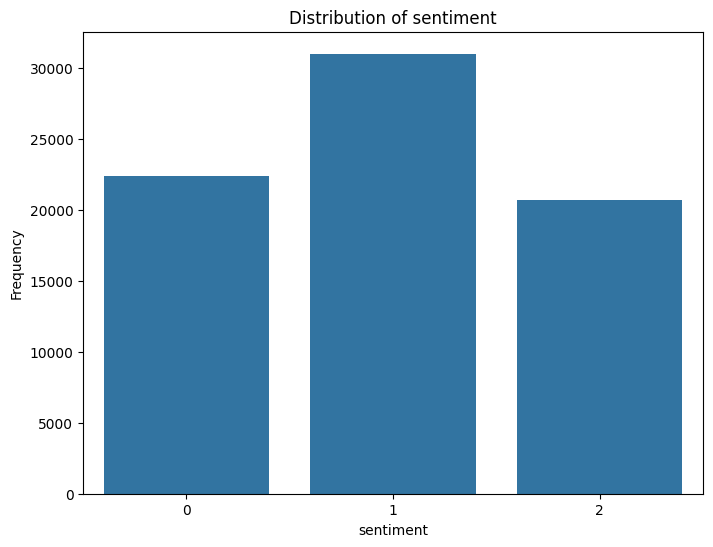

In [ ]:
label_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of sentiment')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      73996 non-null  object
 1   sentiment  73996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

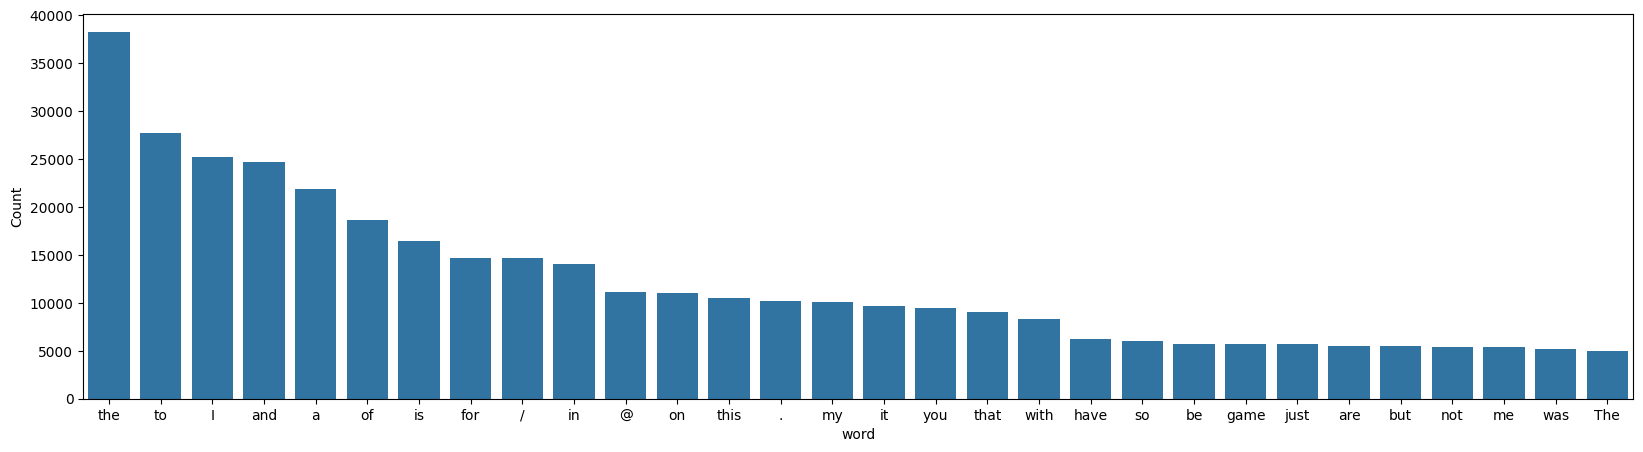

In [ ]:
import nltk
from nltk import FreqDist
freq_words(df['tweet'])

In [ ]:
df['tweet'] = df['tweet'].fillna("").astype(str).str.replace("[^a-zA-Z#]", " ")# remove unwanted characters, numbers and symbols

In [ ]:
# function to remove stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['tweet'] = df['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
sentiment = [remove_stopwords(r.split()) for r in df['tweet']]

# make entire text lowercase
sentiment = [r.lower() for r in sentiment]


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent))
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [ ]:

tokenized_sentiment = pd.Series(sentiment).apply(lambda x: x.split())
print(tokenized_sentiment[5])

['getting', 'borderlands', 'murder', 'all,']


In [ ]:
sentiment_2 = lemmatization(tokenized_sentiment)
print(sentiment_2[5])

['borderland']


In [ ]:
#As you can see, we have not just lemmatized the words but also filtered only nouns and adjectives. Let’s de-tokenize the lemmatized sentiment and plot the most common words.

sentiment_3 = []
for i in range(len(sentiment_2)):
    sentiment_3.append(' '.join(sentiment_2[i]))

df['tweet'] = sentiment_3

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:

df['tweet'] = df['tweet'].apply(remove_urls)
df.head()

,tweet,sentiment
0,borderland,2
1,border,2
2,borderland,2
3,borderland murder,2
4,borderland,2


In [ ]:
empty_list_count = df[df['tweet'].apply(lambda x: x == [])].shape[0]
print(f"Number of rows with empty lists: {empty_list_count}")

Number of rows with empty lists: 0


In [ ]:
print(df.shape)

(73996, 2)


In [ ]:
df.to_csv("finalclean.csv", index=False)
